# Identify optimal deltaT for the quadratic parameterisation

Parameterisation example is quadratic local with mean Antarctic slope (= no slope dependency) as defined in Burgard et al. (2022).
Based on code created by Clara Burgard. Please note that we create the melt rates here, whereas in MeltMIP/ISMIP7 we ask modellers to use their parameterisation implemented in the ice sheet model to produce melt rates for parameter selection.

In [31]:
import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
import multimelt.melt_functions as meltf
from multimelt.constants import *

In [33]:
from parameter_selection_toolbox import *

# Settings

In [34]:
# Directories
figure_dir = 'figures'
data_path="/media/NAS2/ISMIP7/share_with_modellers"
ensemble_path="/mnt/FastStore1/quadratic_out"


# Constants
yearlen = 365.14*24*60*60 # seconds per year
ice_density = 918 # kg/m3
reso=8000 # m model resolution used for melt parameterisation [m]

# parameterisation ensemble table 
p1_name = 'K'
p2_name = 'dummy'

quadratic_present_day_ensemble = "ensemble_quadratic"


# Create parameters

In [89]:
# Create parameter array
#K = xr.DataArray(data=np.arange(0.5e-5,110.05e-5,0.5e-5), dims=['K_dim']).assign_coords({'K_dim': np.arange(0.5e-5,110.05e-5,0.5e-5)}) 
K = xr.DataArray(data=np.arange(0.5e-5,10.05e-5,0.1e-5), dims=['K_dim']).assign_coords({'K_dim': np.arange(0.5e-5,10.05e-5,0.1e-5)}) 
# Comes ut of Term3 fitting, gives sens in ASE up to 10m/a/K which appears too low!!!
#K = xr.DataArray(data=np.array([1e-6,5e-6,1e-5,1e-4, 2.5e-4, 5e-4, 7.5e-4,1e-3]), dims=['K_dim']).assign_coords({'K_dim': np.array([1e-6,5e-6,1e-5,1e-4, 2.5e-4, 5e-4, 7.5e-4,1e-3])}) 
K

<xarray.DataArray (K_dim: 96)> Size: 768B
array([5.0e-06, 6.0e-06, 7.0e-06, 8.0e-06, 9.0e-06, 1.0e-05, 1.1e-05,
       1.2e-05, 1.3e-05, 1.4e-05, 1.5e-05, 1.6e-05, 1.7e-05, 1.8e-05,
       1.9e-05, 2.0e-05, 2.1e-05, 2.2e-05, 2.3e-05, 2.4e-05, 2.5e-05,
       2.6e-05, 2.7e-05, 2.8e-05, 2.9e-05, 3.0e-05, 3.1e-05, 3.2e-05,
       3.3e-05, 3.4e-05, 3.5e-05, 3.6e-05, 3.7e-05, 3.8e-05, 3.9e-05,
       4.0e-05, 4.1e-05, 4.2e-05, 4.3e-05, 4.4e-05, 4.5e-05, 4.6e-05,
       4.7e-05, 4.8e-05, 4.9e-05, 5.0e-05, 5.1e-05, 5.2e-05, 5.3e-05,
       5.4e-05, 5.5e-05, 5.6e-05, 5.7e-05, 5.8e-05, 5.9e-05, 6.0e-05,
       6.1e-05, 6.2e-05, 6.3e-05, 6.4e-05, 6.5e-05, 6.6e-05, 6.7e-05,
       6.8e-05, 6.9e-05, 7.0e-05, 7.1e-05, 7.2e-05, 7.3e-05, 7.4e-05,
       7.5e-05, 7.6e-05, 7.7e-05, 7.8e-05, 7.9e-05, 8.0e-05, 8.1e-05,
       8.2e-05, 8.3e-05, 8.4e-05, 8.5e-05, 8.6e-05, 8.7e-05, 8.8e-05,
       8.9e-05, 9.0e-05, 9.1e-05, 9.2e-05, 9.3e-05, 9.4e-05, 9.5e-05,
       9.6e-05, 9.7e-05, 9.8e-05, 9.9e-05, 1.0e-04])
Coordinates:
  * K_dim    (K_dim) float64 768B 5e-06 6e-06 7e-06 ... 9.8e-05 9.9e-05 0.0001

In [90]:
# Create deltaT corrections array
deltaT = np.linspace(-2,3,101) # go up to 3 for melt sensitivity calculation
deltaT

array([-2.  , -1.95, -1.9 , -1.85, -1.8 , -1.75, -1.7 , -1.65, -1.6 ,
       -1.55, -1.5 , -1.45, -1.4 , -1.35, -1.3 , -1.25, -1.2 , -1.15,
       -1.1 , -1.05, -1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 ,
       -0.65, -0.6 , -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25,
       -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,
        0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,
        0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95,  1.  ,  1.05,  1.1 ,
        1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1.4 ,  1.45,  1.5 ,  1.55,
        1.6 ,  1.65,  1.7 ,  1.75,  1.8 ,  1.85,  1.9 ,  1.95,  2.  ,
        2.05,  2.1 ,  2.15,  2.2 ,  2.25,  2.3 ,  2.35,  2.4 ,  2.45,
        2.5 ,  2.55,  2.6 ,  2.65,  2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,
        2.95,  3.  ])

# Create ensemble, write parameter table

In [91]:
# Load climatology
climatology = xr.load_dataset(os.path.join(data_path, "climatology", "zhou_annual_30_sep", "OI_Climatology_ismip8km_60m_tf_extrap.nc"))
salinity = xr.load_dataset(os.path.join(data_path, "climatology", "zhou_annual_30_sep","OI_Climatology_ismip8km_60m_so_extrap.nc"))

# Load BedMap3
bed = xr.load_dataset(os.path.join(data_path, "topography", "bedmap3_ismip_8km.nc"))

# get thermal forcing at the ice shelf draft
tf_draft = climatology.tf.sel(z=bed['draft'], method='nearest')
tf_draft = tf_draft.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves

so_draft = salinity.so.sel(z=bed['draft'], method='nearest')
#so_draft = so_draft.where(so_draft>0, 0) # remove negative values
S0 = so_draft.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves

U_factor = (c_po / L_i) * beta_coeff_lazero * (g/(2*abs(f_coriolis))) * S0

In [92]:
with open(quadratic_present_day_ensemble+'.txt', 'w') as fh:
    fh.write("ehash K dummy\n")

for i,k in enumerate(K):
    members = []
    
    for dT in deltaT:      
        thermal_forcing = (tf_draft+dT).where(bed.floating_frac>0.5, np.nan)        
        ds = meltf.quadratic_mixed_slope(k, melt_factor, thermal_forcing, thermal_forcing, U_factor, np.arcsin(2.9e-3))*yearinsec
        ds = ds.assign_coords(deltaT=dT)
        members.append(ds)
    ensemble = xr.concat(members, dim='deltaT', coords='minimal')
    ensemble.to_netcdf(os.path.join(ensemble_path,"pd_zhou_"+str(i)+".nc")) 
    with open(quadratic_present_day_ensemble+'.txt', 'a') as fh:
        fh.write(str(i)+" "+str(k.values)+" 1 \n")
    

# Now optimise deltaT

In [93]:
ensemble_table = pd.read_csv('./'+quadratic_present_day_ensemble+'.txt',
                                 sep=r'\s+',index_col=0)

In [94]:
# Supporting Data

# Load imbie2 basins as used on ISMIP
basins = xr.load_dataset(os.path.join(data_path, 'imbie2', "basin_numbers_ismip8km.nc"))
basins = basins.rename({'basinNumber':'basins'})
# shift by 1 to start at 1
basins['basins'] = basins['basins']+1
number_of_basins = int(basins.basins.max())

# present-day melting, melt rates from Paolo et al., 2023, error estimates combined from Paolo and Adusumilli et al., 2020
melt_obs = xr.load_dataset(os.path.join(data_path,'meltmip','melt_paolo_err_adusumilli_ismip8km.nc')) # Field
MeltDataImbie = pd.read_csv(os.path.join(data_path, 'meltmip','Melt_Paolo_Err_Adusumilli_imbie2.csv'), index_col=0) # Aggregated per imbier basin
MeltDataImbie.index = MeltDataImbie.index+1


In [95]:
model_runs = [] 
p1s = []
p2s = []

for i,ehash in enumerate(ensemble_table.index):
    
    p1 = ensemble_table.loc[ehash, p1_name]
    p2 = ensemble_table.loc[ehash, p2_name]
    p1s.append(p1)
    p2s.append(p2) 
    #print(i, 'p1=', p1, ' p2=', p2)

    output_path = os.path.join(ensemble_path, "pd_zhou_"+str(ehash) )
    #print(output_path)

    #try:
    #    #print('Loading dataset')
    #    result_ds = xr.load_dataset(output_path+"_optimised.nc")
    #except:
    ds = xr.open_dataset(os.path.join(output_path+'.nc')) #,decode_timedelta=True)
    ds = ds.rename({'__xarray_dataarray_variable__': 'melt_rate'})
    outname = output_path+"_optimised.nc"
    
    result_ds = select_optimal_deltaT(ds, basins['basins'], None ,MeltDataImbie, 'quadratic', outname, reso, ice_density)
    
    result_ds = result_ds.assign_coords(ehash=ehash)
    model_runs.append(result_ds)

In [96]:
print('Combining datasets')
pd_ensemble_sel = xr.concat(model_runs, dim='ehash', coords='minimal')

# change ehash to C and gammaT dimensions
pd_ensemble_sel = pd_ensemble_sel.assign_coords({ 
    'p1': ('ehash', p1s),
    'p2': ('ehash', p2s)
}).set_index(ehash=['p1', 'p2']).unstack('ehash')

# Save pd_ensemble_sel
pd_ensemble_sel.encoding = {}
pd_ensemble_sel.to_netcdf('Quadratic_ensemble_pd_optimaldeltaT.nc')

Combining datasets


# Create figures

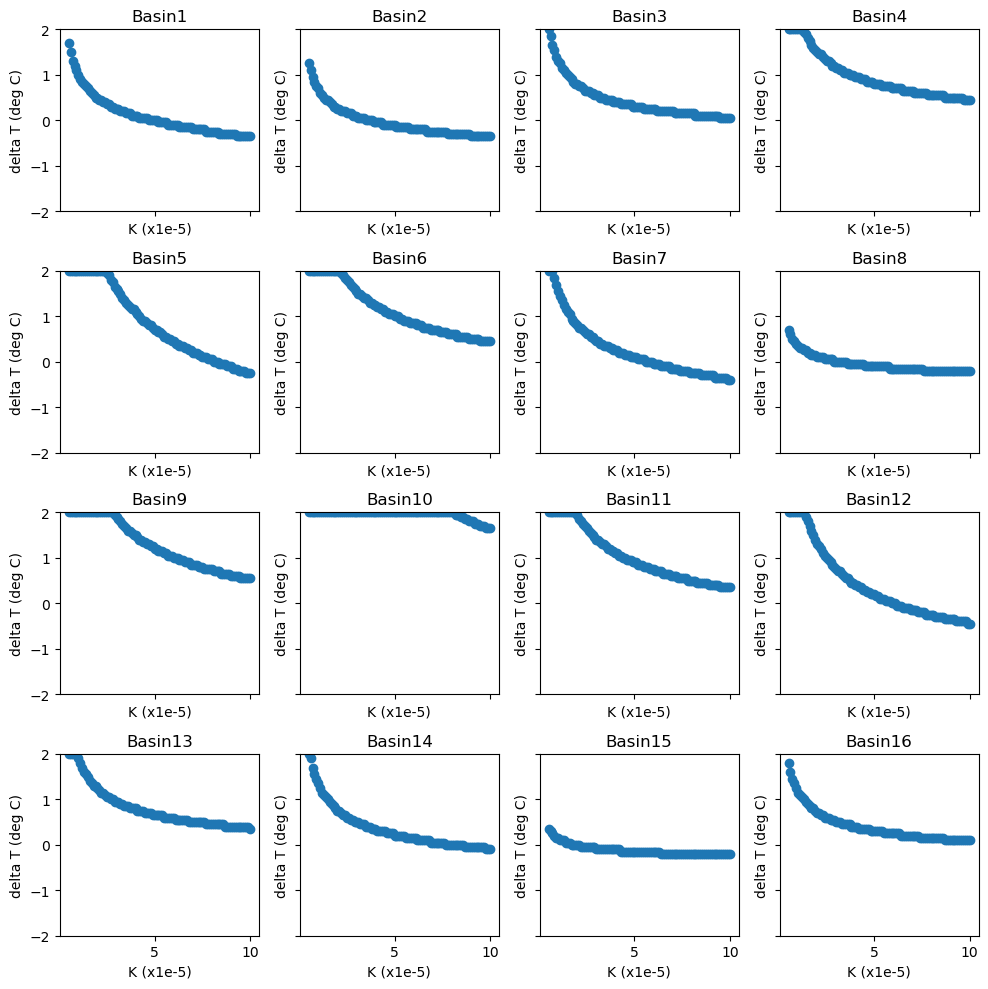

In [97]:
# Plot residuals for each basin, note that white area are where PICO physical constraints all fail
fig,axes = plt.subplots(4,4, sharex=True, sharey=True, figsize=(10, 10))

for i in range(number_of_basins):
    ax = axes.flatten()[i]

    im = ax.scatter(pd_ensemble_sel['p1'].values*1e5, pd_ensemble_sel['optimal_deltaT_per_basin'].sel(basin=i+1).values)
    ax.set_title('Basin'+str( i+1) ) 
    ax.set_xlabel('K (x1e-5)')
    ax.set_ylabel('delta T (deg C)')
    
    ax.set_ylim([-2, 2])

fig.tight_layout()

plt.savefig(os.path.join(figure_dir,'Quadratic_Ensemble_optimalDeltaT_deltaTPerBasin.png'))


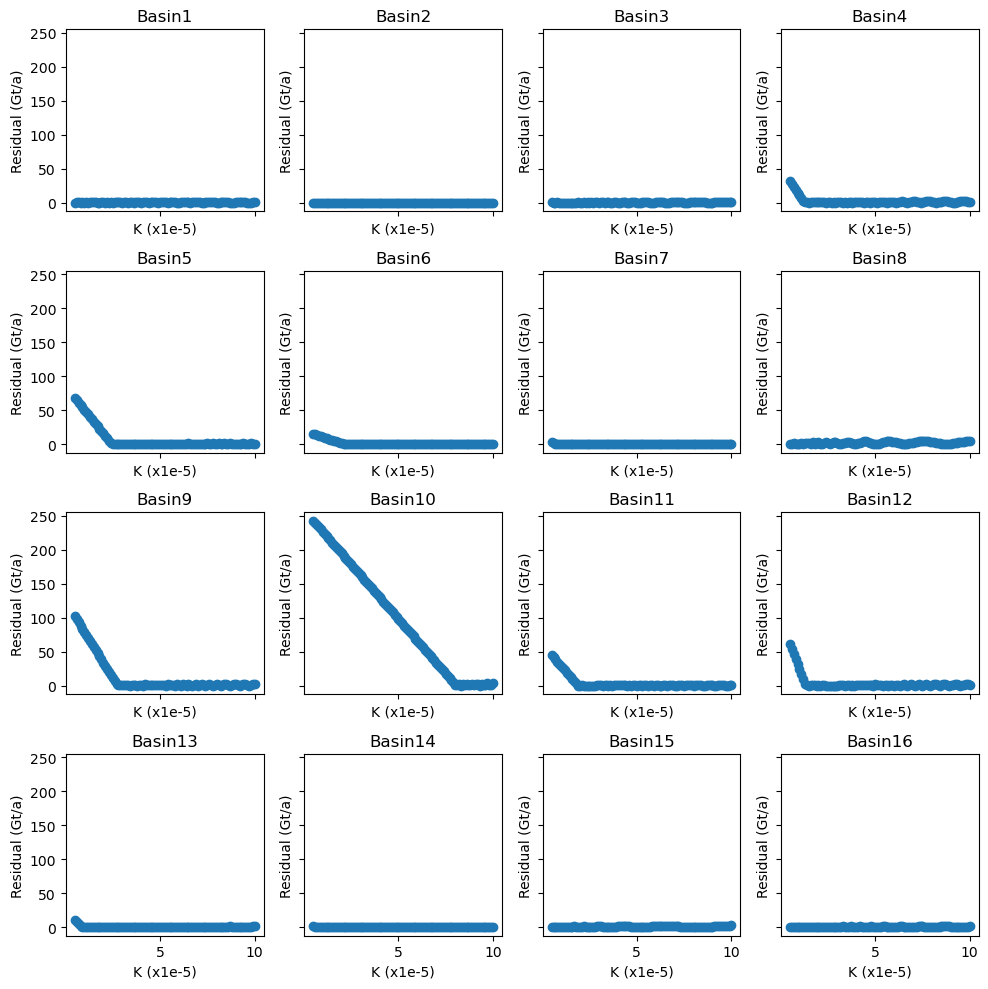

In [98]:
# Plot residuals for each basin, note that white area are where PICO physical constraints all fail
fig,axes = plt.subplots(4,4, sharex=True, sharey=True, figsize=(10, 10))

for i in range(number_of_basins):
    ax = axes.flatten()[i]

    im = ax.scatter(pd_ensemble_sel['p1'].values*1e5, pd_ensemble_sel['residual_per_basin'].sel(basin=i+1).values)
    ax.set_title('Basin'+str( i+1) ) 
    ax.set_xlabel('K (x1e-5)')
    ax.set_ylabel('Residual (Gt/a)')
    #ax.set_ylim([-2, 2])

fig.tight_layout()

plt.savefig(os.path.join(figure_dir,'Quadratic_Ensemble_optimalDeltaT_residualPerBasin.png'))


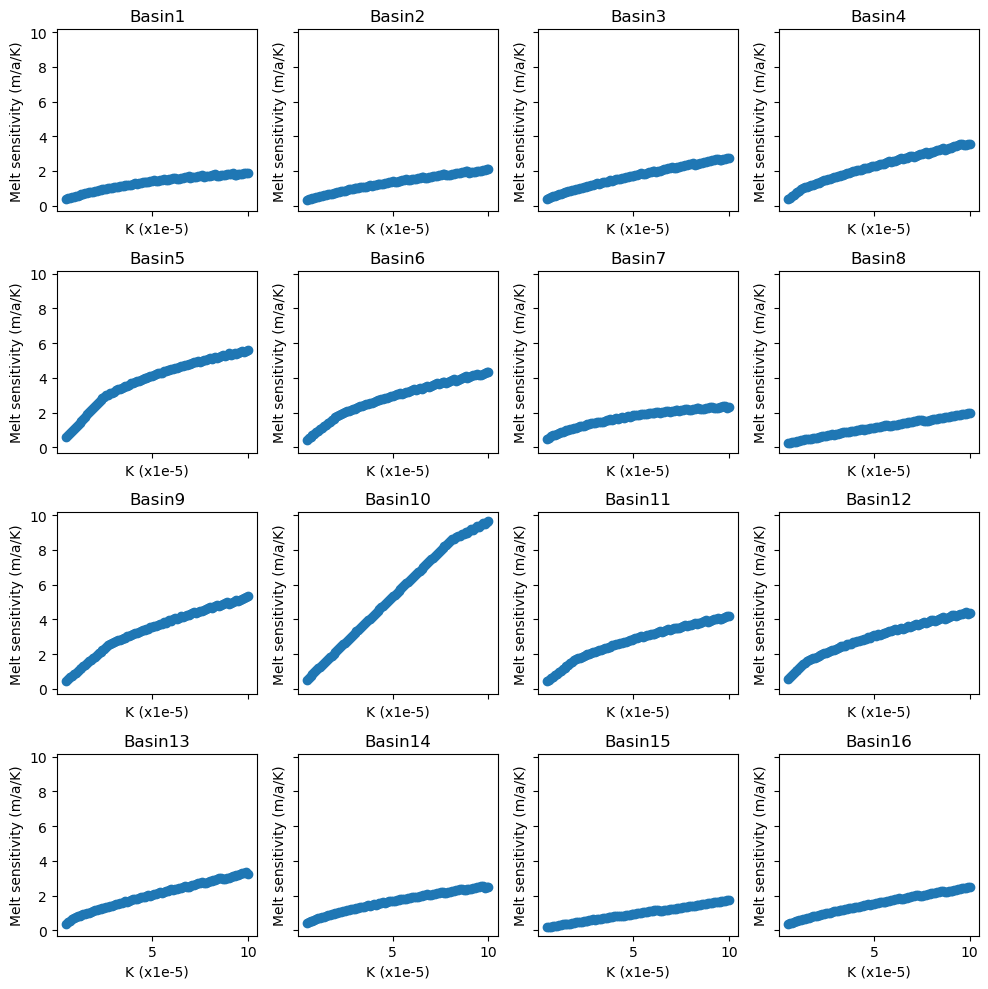

In [99]:
# Plot residuals for each basin, note that white area are where PICO physical constraints all fail
fig,axes = plt.subplots(4,4, sharex=True, sharey=True, figsize=(10, 10))

for i in range(number_of_basins):
    ax = axes.flatten()[i]

    im = ax.scatter(pd_ensemble_sel['p1'].values*1e5, pd_ensemble_sel['sensitivity_per_basin'].sel(basin=i+1).values)
    ax.set_title('Basin'+str( i+1) ) 
    ax.set_xlabel('K (x1e-5)')
    ax.set_ylabel('Melt sensitivity (m/a/K)')
    #ax.set_ylim([-2, 2])

fig.tight_layout()

plt.savefig(os.path.join(figure_dir,'Quadratic_Ensemble_optimalDeltaT_SensitivityPerBasin.png'))


# Apply optimal deltaT to ocean modelling datasets

In [100]:
opt_ensemble = xr.load_dataset('Quadratic_ensemble_pd_optimaldeltaT.nc')

In [101]:
# create ensemble for Mathiot data 
ensemble_names = ["Mathiot23_cold", "Mathiot23_warm"]
datasets = ["Mathiot23_cold_clean_", "Mathiot23_warm_clean_"]

for j,dataset in enumerate(datasets):
    ocean_modelling_data = xr.load_dataset(os.path.join(data_path,"meltmip", "Ocean_Modelling_Data",dataset+"TF.nc"))

    # get thermal forcing at the ice shelf draft
    tf_draft_om = ocean_modelling_data.thermal_forcing.sel(z=bed['draft'], method='nearest')
    tf_draft_om = tf_draft_om.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves

    ocean_modelling_data = xr.load_dataset(os.path.join(data_path,"meltmip", "Ocean_Modelling_Data",dataset+"S.nc"))
    # get thermal forcing at the ice shelf draft
    so_draft = salinity.so.sel(z=bed['draft'], method='nearest')
    S0 = so_draft.where(bed.floating_frac>0.5, np.nan) # mask everything outside of ice shelves
    
    U_factor = (c_po / L_i) * beta_coeff_lazero * (g/(2*abs(f_coriolis))) * S0
        
    for i,k in enumerate(K):
        members = []
        for dT in deltaT:
            thermal_forcing = (tf_draft_om+dT).where(bed.floating_frac>0.5, np.nan)        
            ds = meltf.quadratic_mixed_slope(k, melt_factor, thermal_forcing, thermal_forcing, U_factor, np.arcsin(2.9e-3))*yearinsec
            ds = ds.assign_coords(deltaT=dT)
            members.append(ds)
        ensemble = xr.concat(members, dim='deltaT', coords='minimal')
        ensemble.to_netcdf(os.path.join(ensemble_path,ensemble_names[j]+"_"+str(i)+".nc"))


In [102]:
# Now use selection Krams
#basins = basins['basins']

for ensemble in ensemble_names:
    print(ensemble)
    for i,ehash in enumerate(ensemble_table.index):
        p1 = ensemble_table.loc[ehash, p1_name]
        p2 = ensemble_table.loc[ehash, p2_name]
        #print(ehash, i, 'p1=', p1, ' p2=', p2)

        output_path = os.path.join(ensemble_path, ensemble+"_"+str(ehash) )
        
        ds = xr.open_dataset(os.path.join(output_path+'.nc')) #,decode_timedelta=True)
        ds = ds.rename({'__xarray_dataarray_variable__': 'melt_rate'})
        
        outname = os.path.join(ensemble_path,ensemble+"_"+str(ehash)+"_optimised.nc")
        select_subensemble_using_optimal_deltaT(ds, basins['basins'], opt_ensemble, outname, p1, p2)
        ds.close()


Mathiot23_cold
Mathiot23_warm


In [103]:
# combine datasets
quadratic_present_day_ensemble = "pd_zhou"
quadratic_mathiot_cold_ensemble = "Mathiot23_cold"
quadratic_mathiot_warm_ensemble = "Mathiot23_warm"

# Create ensemble
pd_ensemble = load_melt_rates_into_dataset(quadratic_present_day_ensemble, ensemble_table, ensemble_path, p1_name, p2_name)
# Save pd_ensemble
pd_ensemble.encoding = {}
pd_ensemble.to_netcdf('Ensemble_'+quadratic_present_day_ensemble+'_optimaldeltaT.nc')

mathiot_cold_ensemble = load_melt_rates_into_dataset(quadratic_mathiot_cold_ensemble, ensemble_table, ensemble_path, p1_name, p2_name)
# Save
mathiot_cold_ensemble.encoding = {}
mathiot_cold_ensemble.to_netcdf('Ensemble_'+quadratic_mathiot_cold_ensemble+'_optimaldeltaT.nc')

mathiot_warm_ensemble = load_melt_rates_into_dataset(quadratic_mathiot_warm_ensemble, ensemble_table, ensemble_path, p1_name, p2_name)
# Save
mathiot_warm_ensemble.encoding = {}
mathiot_warm_ensemble.to_netcdf('Ensemble_'+quadratic_mathiot_warm_ensemble+'_optimaldeltaT.nc')


Loading pd_zhou into one dataset...
Combining datasets
Loading Mathiot23_cold into one dataset...
Combining datasets
Loading Mathiot23_warm into one dataset...
Combining datasets


In [ ]:
quadratic_present_day_ensemble = "pd_zhou"
quadratic_mathiot_cold_ensemble = "Mathiot23_cold"
quadratic_mathiot_warm_ensemble = "Mathiot23_warm"

In [ ]:
# Supporting Data

# Load imbie2 basins as used on ISMIP
basins = xr.load_dataset(os.path.join(data_path, 'imbie2', "basin_numbers_ismip8km.nc"))
basins = basins.rename({'basinNumber':'basins'}) # basins now start at 0

nBasins = int(basins.basins.max())

# present-day melting, melt rates from Paolo et al., 2023, error estimates combined from Paolo and Adusumilli et al., 2020
melt_obs = xr.load_dataset(os.path.join(data_path, 'meltmip','melt_paolo_err_adusumilli_ismip8km.nc')) # Field
MeltDataImbie = pd.read_csv(os.path.join(data_path, 'meltmip','Melt_Paolo_Err_Adusumilli_imbie2.csv'), index_col=0) # Aggregated per imbier basin

# Buttressing Flux Response Numbers, remapped to 8km 
bfrn = xr.load_dataset(os.path.join(data_path, 'meltmip',"BFRN_ismip8km.nc"))
nBins = 10

In [ ]:
# Load ensembles
pd_ensemble = xr.load_dataset('Ensemble_'+quadratic_present_day_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])
mathiot_cold_ensemble = xr.load_dataset('Ensemble_'+quadratic_mathiot_cold_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])
mathiot_warm_ensemble = xr.load_dataset('Ensemble_'+quadratic_mathiot_warm_ensemble+'_optimaldeltaT.nc', drop_variables=['timestamp'])

In [ ]:
mask = bed.floating_frac>0.5

In [ ]:
data_path

Sampling, this might take a moment...


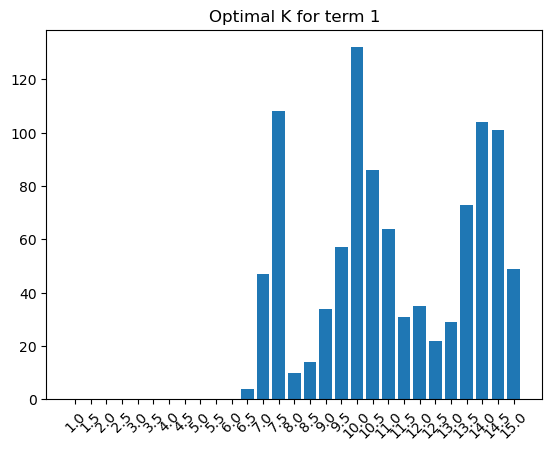

In [36]:
sample_size=1000
min_p1_t1, min_p2_t1, min_coords_t1 = calculate_objective_function('term1', sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)


fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes#.flatten()[0]

bin_edges = np.array( np.append(K-0.01e-5, K[-1]+0.01e-5) )
counts, _ = np.histogram(np.array(min_p1_t1), bins= bin_edges)
positions = np.arange(len(counts))
ax.bar(positions, counts, width=0.8)
labels = np.round(K.values*1e5, 1)
ax.set_xticks(positions, labels, rotation=45)
ax.set_title('Optimal K for term 1')

plt.savefig(os.path.join(figure_dir,'quadratic_present_day_Hist_Sample'+str(sample_size)+'_Term1.png'))  


Sampling, this might take a moment...


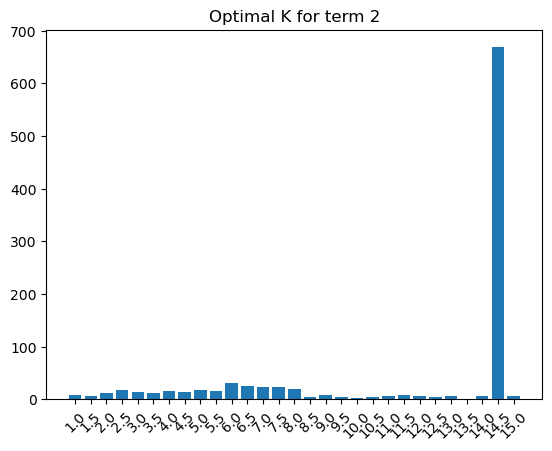

In [37]:
sample_size=1000
min_p1_t2, min_p2_t2, min_coords_t2 = calculate_objective_function('term2', sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes#.flatten()[0]

bin_edges = np.array( np.append(K-0.01e-5, K[-1]+0.01e-5) )
counts, _ = np.histogram(np.array(min_p1_t2), bins= bin_edges)
positions = np.arange(len(counts))
ax.bar(positions, counts, width=0.8)
labels = np.round(K.values*1e5, 1)
ax.set_xticks(positions, labels, rotation=45)
ax.set_title('Optimal K for term 2')

plt.savefig(os.path.join(figure_dir,'quadratic_present_day_Hist_Sample'+str(sample_size)+'_Term2.png'))  


Sampling, this might take a moment...


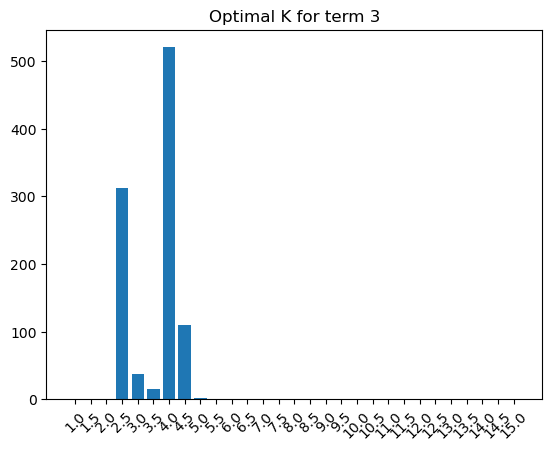

In [38]:
sample_size=1000
min_p1_t3, min_p2_t3, min_coords_t3 = calculate_objective_function('term3', sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes#.flatten()[0]

bin_edges = np.array( np.append(K-0.01e-5, K[-1]+0.01e-5) )
counts, _ = np.histogram(np.array(min_p1_t3), bins= bin_edges)
positions = np.arange(len(counts))
ax.bar(positions, counts, width=0.8)
labels = np.round(K.values*1e5, 1)
ax.set_xticks(positions, labels, rotation=45)
ax.set_title('Optimal K for term 3')

plt.savefig(os.path.join(figure_dir,'quadratic_present_day_Hist_Sample'+str(sample_size)+'_Term3.png'))  


Sampling, this might take a moment...


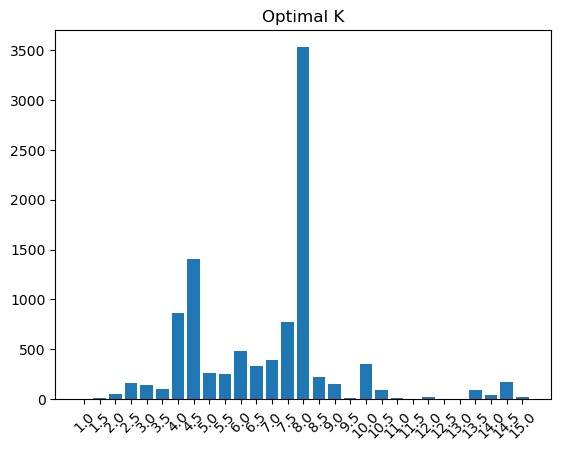

In [39]:
sample_size=10000
min_p1, min_p2, min_coords = calculate_objective_function('all', sample_size, basins['basins'], mask, bfrn, reso, ice_density, melt_obs, MeltDataImbie, data_path, 
                              pd_ensemble, mathiot_cold_ensemble, mathiot_warm_ensemble)

fig,axes = plt.subplots(1,1, sharex=False, sharey=False)
ax = axes#.flatten()[0]

bin_edges = np.array( np.append(K-0.01e-5, K[-1]+0.01e-5) )
counts, _ = np.histogram(np.array(min_p1), bins= bin_edges)
positions = np.arange(len(counts))
ax.bar(positions, counts, width=0.8)
labels = np.round(K.values*1e5, 1)
ax.set_xticks(positions, labels, rotation=45)
ax.set_title('Optimal K')

plt.savefig(os.path.join(figure_dir,'quadratic_present_day_Hist_Sample'+str(sample_size)+'_All.png'))  


In [40]:
#print('min = ', np.min(np.array(min_p1)))
print('1st = ', np.percentile(np.array(min_p1), 1))
print('5th = ', np.percentile(np.array(min_p1), 5))
print('median = ', np.median(np.array(min_p1)))
print('95th = ', np.percentile(np.array(min_p1), 95))
print('99th = ', np.percentile(np.array(min_p1), 99))
#print('max = ', np.max(np.array(min_p1)))

# To incorporate a wider range of uncertainty, it might make sense to use 1st and 99th percentiles.

1st =  2.5000000000000005e-05
5th =  4.000000000000001e-05
median =  7.500000000000002e-05
95th =  0.0001
99th =  0.000145
